In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image # Keep using this, it's a great helper for loading

In [2]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np

train_path = "/content/drive/MyDrive/collab_data/subset_data"
test_path = "/content/drive/MyDrive/collab_data/test"

train = []
for filename in os.listdir(train_path):
    if filename.endswith(".jpg"):
        img = image.load_img(os.path.join(train_path, filename), target_size=(64, 64))
        train.append(image.img_to_array(img))
train = np.array(train)

test = []
for filename in os.listdir(test_path):
    if filename.endswith(".jpg"):
        img = image.load_img(os.path.join(test_path, filename), target_size=(64, 64))
        test.append(image.img_to_array(img))
test = np.array(test)

# This normalization is still correct
train = train.astype('float32') / 255.
test = test.astype('float32') / 255.

In [3]:
print("cat_train", train.shape)
print("cat_test", test.shape)

cat_train (5000, 64, 64, 3)
cat_test (19, 64, 64, 3)


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def show_data(X, n=10, title=""):
    plt.figure(figsize=(15, 5))
    n = min(n, len(X))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X[i]) # Use plt.imshow directly
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize=20)

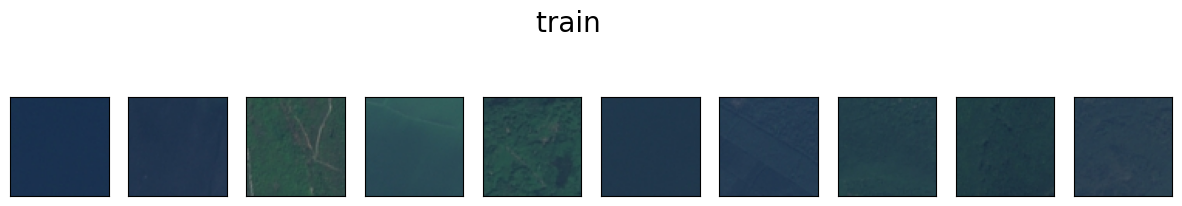

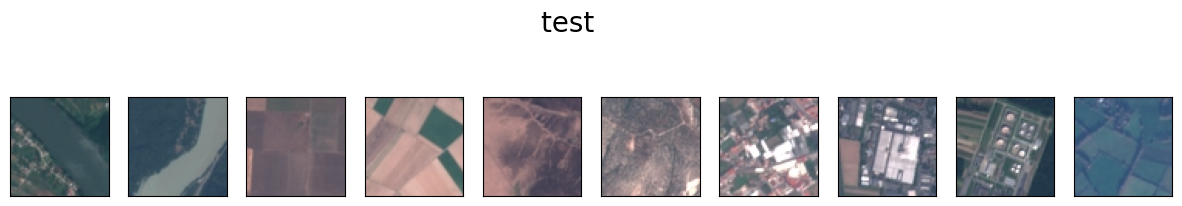

In [5]:
show_data(train, title="train ")
show_data(test, title="test ")

In [6]:
# Cell 6: Install PyTorch and compressai
!pip install torch torchvision
!pip install compressai
!pip install scikit-image # For metrics

In [7]:
# Cell 7: Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Import from the compressai (PyTorch) library
from compressai.layers import GDN
from compressai.entropy_models import EntropyBottleneck

# Import metrics libraries
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.patheffects as path_effects

# Check for GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [8]:
# Cell 8: Convert Data to PyTorch Tensors & Loaders

# 1. Transpose the data from (N, H, W, C) to (N, C, H, W)
# PyTorch expects channels first: (N, 3, 64, 64)
train_pytorch = np.transpose(train, (0, 3, 1, 2))
test_pytorch = np.transpose(test, (0, 3, 1, 2))

# 2. Convert NumPy arrays to PyTorch Tensors
# We create a simple TensorDataset where the input and target are the same
train_dataset = TensorDataset(torch.from_numpy(train_pytorch).float())
test_dataset = TensorDataset(torch.from_numpy(test_pytorch).float())

# 3. Create DataLoaders
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print(f"Original NumPy shape: {train.shape}")
print(f"New PyTorch Tensor shape: {train_pytorch.shape}")

Original NumPy shape: (5000, 64, 64, 3)
New PyTorch Tensor shape: (5000, 3, 64, 64)


In [23]:
# Cell 9: New Model Architecture (PyTorch & compressai)

class PaperAutoencoder(nn.Module):
    """
    A PyTorch nn.Module implementation of the architecture in Figure 3.1.
    """
    def __init__(self, N=128):
        super().__init__()
        self.N = N

        # --- The Encoder (Analysis Transform) ---
        self.encoder = nn.Sequential(
            nn.Conv2d(3, self.N, kernel_size=5, stride=2, padding=2),
            GDN(self.N),
            nn.Conv2d(self.N, self.N, kernel_size=5, stride=2, padding=2),
            GDN(self.N),
            nn.Conv2d(self.N, self.N, kernel_size=5, stride=2, padding=2),
            GDN(self.N),
            nn.Conv2d(self.N, self.N, kernel_size=5, stride=2, padding=2),
        )

        # --- The Entropy Bottleneck ---
        self.entropy_bottleneck = EntropyBottleneck(self.N)

        # --- The Decoder (Synthesis Transform) ---
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.N, self.N, kernel_size=5, stride=2, padding=2, output_padding=1),
            GDN(self.N, inverse=True),
            nn.ConvTranspose2d(self.N, self.N, kernel_size=5, stride=2, padding=2, output_padding=1),
            GDN(self.N, inverse=True),
            nn.ConvTranspose2d(self.N, self.N, kernel_size=5, stride=2, padding=2, output_padding=1),
            GDN(self.N, inverse=True),
            # Final layer maps back to 3 channels (RGB)
            nn.ConvTranspose2d(self.N, 3, kernel_size=5, stride=2, padding=2, output_padding=1),
        )

        # --- Final Output Activation ---
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """The forward pass of the model."""
        y = self.encoder(x)
        y_hat, y_likelihoods = self.entropy_bottleneck(y)
        x_hat = self.decoder(y_hat)
        x_hat = self.sigmoid(x_hat) # Scale output to [0, 1]
        return x_hat, y_likelihoods

    def calculate_loss(self, x, x_hat, y_likelihoods, target_bpp, beta):
        """
        Calculates the Rate-Constrained loss.
        L = D + beta * (R - R_target)^2
        """

        # D: Distortion Loss (MSE)
        distortion_loss = torch.mean((x - x_hat).pow(2))

        # R: Rate Loss (Entropy in bits per pixel)
        num_pixels = x.shape[2] * x.shape[3]
        rate_loss = -torch.sum(torch.log2(y_likelihoods)) / (x.shape[0] * num_pixels) # bpp

        # --- NEW LOSS CALCULATION ---
        # This is the penalty for missing our target BPP
        rate_penalty = (rate_loss - target_bpp).pow(2)

        # L: Total Loss
        total_loss = distortion_loss + (beta * rate_penalty)

        return total_loss, distortion_loss, rate_loss

In [26]:
# Cell 10: Model Training (Manual PyTorch Loop)

# --- Hyperparameters ---
TARGET_BPP = 1.0  # <-- Our target (24x compression = 1.0 bpp)
BETA = 10.0     # <-- How strictly to enforce the target
epochs = 100     # <-- Train for longer (100 was from your example)
learning_rate = 1e-4
# ---------------------

# 1. Instantiate model and send to device (GPU or CPU)
AE = PaperAutoencoder().to(device)

# 2. Set up optimizer
optimizer = optim.Adam(AE.parameters(), lr=learning_rate)

# 3. Store history
history = {
    'loss': [], 'distortion_loss': [], 'rate_loss': [],
    'val_loss': [], 'val_distortion_loss': [], 'val_rate_loss': []
}

# 4. --- Training Loop ---
print(f"Starting training for {epochs} epochs...")
print(f"Goal: Minimize Distortion (PSNR) while targeting {TARGET_BPP:.2f} BPP.")

for epoch in range(epochs):

    # --- Training ---
    AE.train() # Set model to training mode
    train_loss, train_d, train_r = 0, 0, 0

    for batch in train_loader:
        x = batch[0].to(device) # Data is [inputs]

        # 1. Forward pass
        x_hat, y_likelihoods = AE(x)

        # 2. Calculate loss (using new function)
        loss, d_loss, r_loss = AE.calculate_loss(x, x_hat, y_likelihoods, TARGET_BPP, BETA)

        # 3. Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_d += d_loss.item()
        train_r += r_loss.item()

    # --- Validation ---
    AE.eval() # Set model to evaluation mode
    val_loss, val_d, val_r = 0, 0, 0

    with torch.no_grad(): # Disable gradient calculation
        for batch in test_loader:
            x = batch[0].to(device)
            x_hat, y_likelihoods = AE(x)
            # Use same loss function for validation
            loss, d_loss, r_loss = AE.calculate_loss(x, x_hat, y_likelihoods, TARGET_BPP, BETA)

            val_loss += loss.item()
            val_d += d_loss.item()
            val_r += r_loss.item()

    # --- Log Epoch Results ---
    train_loss /= len(train_loader)
    train_d /= len(train_loader)
    train_r /= len(train_loader)
    val_loss /= len(test_loader)
    val_d /= len(test_loader)
    val_r /= len(test_loader)

    history['loss'].append(train_loss)
    history['distortion_loss'].append(train_d)
    history['rate_loss'].append(train_r)
    history['val_loss'].append(val_loss)
    history['val_distortion_loss'].append(val_d)
    history['val_rate_loss'].append(val_r)

    # --- FIX: Updated this line to show all losses ---
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Loss: {train_loss:.4f} | D: {train_d:.4f} | R: {train_r:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val D: {val_d:.4f} | Val R: {val_r:.4f}")

print("Training complete.")

Starting training for 100 epochs...
Goal: Minimize Distortion (PSNR) while targeting 1.00 BPP.
Epoch 1/100 | Loss: 26.4086 | D: 0.0268 | R: 2.6239 | Val Loss: 24.8946 | Val D: 0.0138 | Val R: 2.5774
Epoch 2/100 | Loss: 23.5922 | D: 0.0128 | R: 2.5354 | Val Loss: 22.2995 | Val D: 0.0180 | Val R: 2.4927
Epoch 3/100 | Loss: 21.0632 | D: 0.0103 | R: 2.4508 | Val Loss: 19.8445 | Val D: 0.0107 | Val R: 2.4083
Epoch 4/100 | Loss: 18.6998 | D: 0.0096 | R: 2.3669 | Val Loss: 17.5756 | Val D: 0.0109 | Val R: 2.3253
Epoch 5/100 | Loss: 16.5198 | D: 0.0087 | R: 2.2847 | Val Loss: 15.4889 | Val D: 0.0100 | Val R: 2.2441
Epoch 6/100 | Loss: 14.5292 | D: 0.0080 | R: 2.2048 | Val Loss: 13.5934 | Val D: 0.0103 | Val R: 2.1655
Epoch 7/100 | Loss: 12.7279 | D: 0.0079 | R: 2.1276 | Val Loss: 11.8814 | Val D: 0.0088 | Val R: 2.0896
Epoch 8/100 | Loss: 11.1086 | D: 0.0077 | R: 2.0534 | Val Loss: 10.3504 | Val D: 0.0082 | Val R: 2.0170
Epoch 9/100 | Loss: 9.6594 | D: 0.0075 | R: 1.9822 | Val Loss: 8.9799 | V

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:13: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:13: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-716261032.py:8: SyntaxWarning: invalid escape sequence '\l'
  fig.suptitle(f'Model Training History (Trained with $\lambda$={LAMBDA})', fontsize=16)
/tmp/ipython-input-716261032.py:13: SyntaxWarning: invalid escape sequence '\l'
  ax1.set_title('1. Total Loss (L = $\lambda$D + R)')


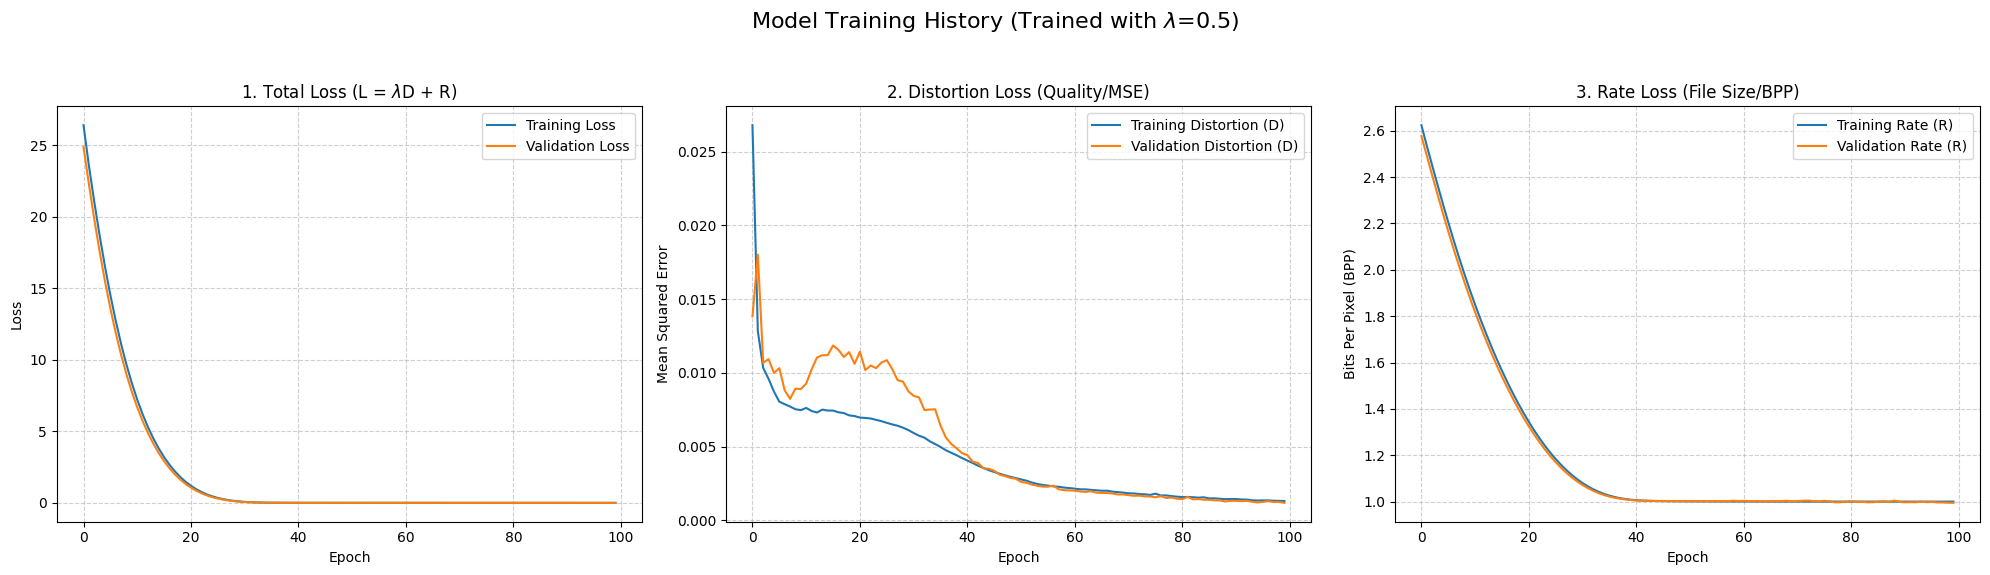

In [27]:
# Cell 11: Plot Loss Curves

# The 'history' dictionary was created in Cell 10 during training
history_data = history

# Create a figure with 3 subplots in one row
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle(f'Model Training History (Trained with $\lambda$={LAMBDA})', fontsize=16)

# --- Plot 1: Total Loss (L = lambda*D + R) ---
ax1.plot(history_data['loss'], label='Training Loss')
ax1.plot(history_data['val_loss'], label='Validation Loss')
ax1.set_title('1. Total Loss (L = $\lambda$D + R)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)

# --- Plot 2: Distortion Loss (Quality / MSE) ---
ax2.plot(history_data['distortion_loss'], label='Training Distortion (D)')
ax2.plot(history_data['val_distortion_loss'], label='Validation Distortion (D)')
ax2.set_title('2. Distortion Loss (Quality/MSE)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean Squared Error')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)

# --- Plot 3: Rate Loss (File Size / BPP) ---
ax3.plot(history_data['rate_loss'], label='Training Rate (R)')
ax3.plot(history_data['val_rate_loss'], label='Validation Rate (R)')
ax3.set_title('3. Rate Loss (File Size/BPP)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Bits Per Pixel (BPP)')
ax3.legend()
ax3.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
plt.show()

Successfully processed 19 images.
Average BPP on test set: 0.9948 bpp


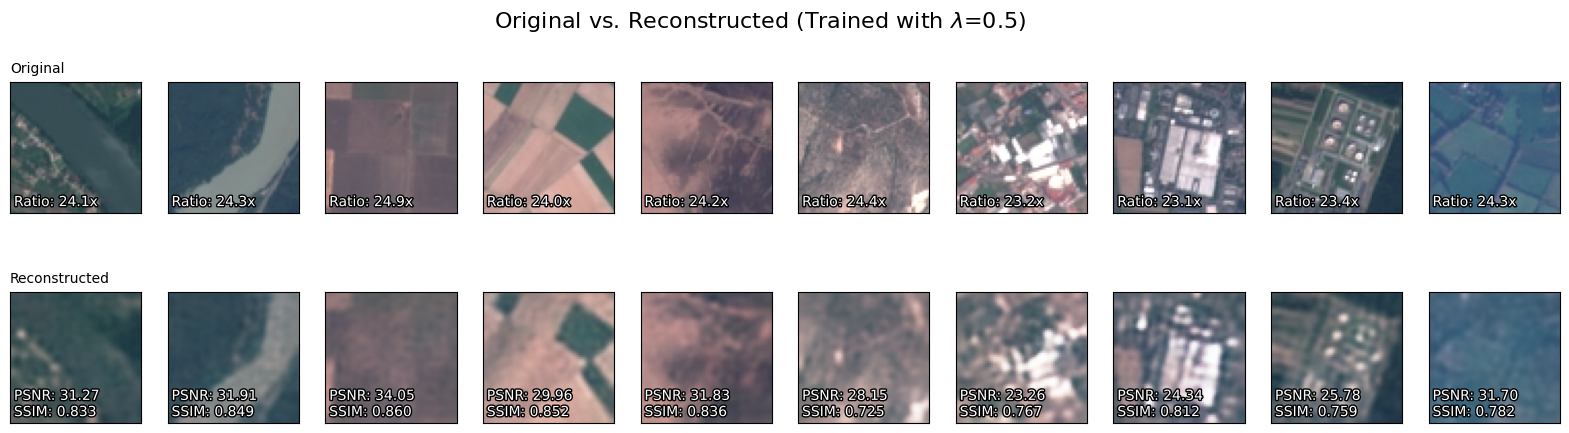

In [28]:
# Cell 12: Predict, Calculate Metrics & Visualize (Updated)

AE.eval() # Set model to evaluation mode
num_pixels = 64 * 64

# We'll store results in lists
original_images = []
reconstructed_images = []
bpp_values = []

with torch.no_grad():
    # We iterate through the test_loader *once* to get all images
    for batch in test_loader:
        x = batch[0].to(device)
        x_hat, y_likelihoods = AE(x)

        # Calculate BPP for each image in the batch
        # We still need BPP to calculate the compression ratio
        bpp_batch = -torch.sum(torch.log2(y_likelihoods), axis=(1, 2, 3)) / num_pixels

        # --- Convert to NumPy for Plotting ---
        orig_np = np.transpose(x.cpu().numpy(), (0, 2, 3, 1))
        recon_np = np.transpose(x_hat.cpu().numpy(), (0, 2, 3, 1))

        original_images.extend(orig_np)
        reconstructed_images.extend(recon_np)
        bpp_values.extend(bpp_batch.cpu().numpy())

# Convert lists to big NumPy arrays
original_images = np.array(original_images)
reconstructed_images = np.array(reconstructed_images)
bpp_values = np.array(bpp_values)

print(f"Successfully processed {len(original_images)} images.")
print(f"Average BPP on test set: {np.mean(bpp_values):.4f} bpp")

# --- Visualization Function (Updated) ---

text_style = dict(horizontalalignment='left', verticalalignment='bottom',
                  fontsize=10, color='white',
                  path_effects=[path_effects.withStroke(linewidth=2, foreground='black')])

def show_original_vs_reconstructed(original, reconstructed, bpp_values, n=10):
    plt.figure(figsize=(20, 5))
    n = min(n, len(original))

    # 24 bits per pixel for an uncompressed 8-bit RGB image
    UNCOMPRESSED_BPP = 24.0

    for i in range(n):
        recon_img = np.clip(reconstructed[i], 0, 1)
        orig_img = np.clip(original[i], 0, 1)

        # --- Calculate Quality Metrics ---
        psnr_val = psnr(orig_img, recon_img, data_range=1.0)
        ssim_val = ssim(orig_img, recon_img, channel_axis=-1, data_range=1.0)

        # --- Calculate Compression Metrics ---
        bpp_val = bpp_values[i]
        # Calculate compression ratio from bpp
        compression_ratio = UNCOMPRESSED_BPP / bpp_val

        # --- Display Original ---
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(orig_img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title("Original", loc='left', fontsize=10)

        # FIX: Display *only* the compression ratio
        comp_text = f"Ratio: {compression_ratio:.1f}x"
        ax.text(0.03, 0.03, comp_text, transform=ax.transAxes, **text_style)

        # --- Display Reconstruction ---
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(recon_img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title("Reconstructed", loc='left', fontsize=10)

        # FIX: This already shows just PSNR and SSIM
        metrics_text = f"PSNR: {psnr_val:.2f}\nSSIM: {ssim_val:.3f}"
        ax.text(0.03, 0.03, metrics_text, transform=ax.transAxes, **text_style)

    # This will automatically use the LAMBDA=0.5 from your Cell 10
    plt.suptitle(rf"Original vs. Reconstructed (Trained with $\lambda$={LAMBDA})", fontsize=16)
    plt.show()

# --- Run the Visualization ---
show_original_vs_reconstructed(original_images, reconstructed_images, bpp_values)